In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.constants as const
from scipy.integrate import odeint

For more details, please read:
> **Synthetic radiation diagnostics as a pathway for studying plasma dynamics - from advanced accelerators to astrophysical observations**
Pausch, R. (2019) PhD Thesis
https://doi.org/10.5281/zenodo.3616045

section **6.2.2**

# Fundamental parameters

## user parameters

- $n_e$ electron (base) density
- $a_0 = \frac{q_e \cdot E}{m_e \cdot c \cdot \omega_0}$ normalized laser field strength (maximum value of laser)
- $E$ electric field (in above case at maximum intensity of laser)
- $m_e$ electron mass
- $c$ speed of light
- $\omega_0 = \frac{2 \pi c}{\lambda_0}$ laser frequency
- $\lambda_0$ laser wavelength
- $\tau = \tau_t \cdot c$ laser pulse length
- $\tau_t$ laser pulse duration



In [2]:
# (base) electron density:
n_e = 1.0e18*1e6 # [m^-3]

# normalized laser strength (peak of laser pulse)
a0 = 1.5

# laser wavelength:
lambda_0 = 0.8e-6 # [m]

# laser pulse length
tau = 15e-15*const.speed_of_light # [m]

## derived quantities
- $\omega_\mathrm{pe}= \sqrt{\frac{n_e q_e^2}{\varepsilon_0 m_e}}$ plasma frequency
- $\varepsilon_0$ vacuum permittivity
- $\omega_0$ *see above*
- $v_g = c \cdot \sqrt{1 - \frac{\omega_\mathrm{pe}^2}{\omega_0^2}}$ laser group velocity

In [3]:
# plasma freqency [s^-1]
omega_pe = np.sqrt((n_e * const.elementary_charge**2)/(const.electron_mass * const.epsilon_0))

# laser frequency [s^-1]
omega_0 = 2. * np.pi * const.speed_of_light / lambda_0

# laser group velocity [m/s]
v_g = const.speed_of_light * np.sqrt(1. - omega_pe**2 / omega_0**2)
print("speed of laser with respect to speed of light in vacuum:", v_g / const.speed_of_light)

speed of laser with respect to speed of light in vacuum: 0.9997129257495452


assumption:
$v_g \approx v_\phi$ (laser group velocity is approximately plasma phase velocity)

- $v_\phi = \frac{\omega_\mathrm{pe}}{k_\mathrm{pe}}$ plasma phase velocity
- $k_p = \frac{\omega_\mathrm{pe}}{c}$ plasma wave number
- $\beta_p = \frac{v_\phi}{c}$ normalized plasma phase velocity 

In [4]:
v_phi = v_g

# plasma wave number
kp = omega_pe / const.speed_of_light # [m^-1]

# normalized plasma phase velocity 
betap = v_phi / const.speed_of_light

How long will a plama wave be approximately?

In [5]:
print("Plasma wave length:", 2*np.pi*const.speed_of_light/omega_pe/1e-6, "µm")

Plasma wave length: 33.38943270215429 µm


## Collect parameters

In [6]:
param = {}
param["a0"] = a0
param["kp"] = kp
param["betap"] = betap
param["omega_pe"] = omega_pe

print(param)

{'a0': 1.5, 'kp': 188178.85776101233, 'betap': 0.9997129257495452, 'omega_pe': 56414602311806.266}


# Setup analytical laser description

comoving coordinates where the plasma density and the laser will be described on (domain of a function)
$$ \xi = z - c \cdot t $$
(more precisely it should not be $c$ but $v_g$). 

In [7]:
xi = np.linspace(-80e-6, 20e-6, 20000)[::-1] # [m] (inverse order)

## laser envelope
assuming a simple Gaussian envelope
$$ \hat{E}(\xi) = a_0 \cdot \mathrm{e}^{-\left(\frac{\xi}{\tau}\right)^2} $$

In [8]:
def calc_laser_env(xi, a0=1.0, L=tau):
    return a0 * np.exp(-xi**2 / L**2)

## laser with oscilation
$$ E(\xi) = \hat{E}(\xi) \cdot \cos(2 \pi \xi/\lambda_0) $$

In [9]:
def calc_laser(xi, a0=1.0, L=tau, lambda0=lambda_0):
    return calc_laser_env(xi, a0, L) * np.cos(2. * np.pi * xi / lambda0)

## visualize laser

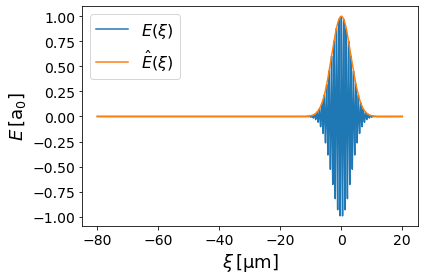

In [10]:
plt.plot(xi/1e-6, calc_laser(xi), label=r"$E(\xi)$")
plt.plot(xi/1e-6, calc_laser_env(xi), label=r"$\hat{E}(\xi)$")

plt.legend(loc=2, fontsize=16)

plt.xlabel(r"$\xi \, \mathrm{[\mu m]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$E \, \mathrm{[a_0]}$", fontsize=18)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

# Analytical 1D plasma wake model

Compute potential $\Phi$ induced by the laser's ponderomotive force to derive the relevant quantities accelerating electric field $E_z$ and electron density $n_e$ from that potential. 

## Solve for normalized potential $\Psi$
Definition of normalized potential $\Psi$
$$ \Psi (\xi) = \frac{q_e \cdot \Phi(\xi)}{m_e c^2} $$

### Differential equation to compute $\Psi$

$$ \frac{\partial^2 \Psi}{\partial \xi^2} = k_p^2 \gamma_p^2 \left[ \beta_p \left( 1 - \frac{1+a^2(\xi)}{\gamma_p^2 (1 + \Psi(\xi))} \right)^{-1/2} -1 \right] $$

In [11]:
# differential equation

def ode_potential_d2Phi_d2xi(Phi, xi):
    k_p = param["kp"]
    beta_p = param["betap"]
    gamma_p = 1./np.sqrt(1 - beta_p**2)
    a = calc_laser_env(xi, a0=param["a0"])
    localPhi = Phi[0]
    d2Phi_d2xi = k_p**2 * gamma_p**2 * (beta_p / np.sqrt(1. - (1+a**2)/(gamma_p**2 * (1. + localPhi)**2)) -1.)
    return [Phi[1], d2Phi_d2xi]

### Start values
We know that in front of the laser (at $\xi \rightarrow \infty$), both the (normalize) potential $\Psi$ and its derivative $\Psi^\prime = \frac{\partial \Psi}{\partial \xi}$ are zero. 

In [12]:
# start value

Phi0 = np.array([0., 0.])
Phi = odeint(ode_potential_d2Phi_d2xi, Phi0, xi)

## Derive accelerating electric field from potential

$$ \frac{E_z(\xi)}{E_0} = - \frac{c}{\omega_\mathrm{pe}} \frac{\partial \Psi(\xi)}{\partial \xi} $$

In [13]:
# electric field from potential

def calc_Ez_per_E0(Phi, xi):
    c = const.speed_of_light
    omega_p = param["omega_pe"]
    delta_xi =  xi[1] - xi[0]
    # ATTENTION: minus sign added
    return -c/omega_p *  np.diff(Phi[:,0]) / delta_xi / param["a0"]

In [14]:
E = calc_Ez_per_E0(Phi, xi)

## Derive density from potential

$$ \frac{n_e(\xi)}{n_0} = \gamma_p^2 \beta_p \left[ \left( 1 - \frac{1 + a^1(\xi)}{\gamma_p^2 ( 1 + \Psi(\xi) )^2} \right)^{-1/2} - \beta_p \right] $$

In [15]:
# density from potential

def calc_density(Phi, xi):
    k_p = param["kp"]
    beta_p = param["betap"]
    gamma_p = 1./np.sqrt(1 - beta_p**2)
    a = calc_laser_env(xi, a0=param["a0"])
    localPhi = Phi[:, 0]
    return  gamma_p**2 * beta_p * ( 1.0/ np.sqrt(1. - (1+a**2)/(gamma_p**2 * (1. + localPhi)**2)) - beta_p)


In [16]:
np_per_n0 = calc_density(Phi, xi)

# Visualize laser wakefield

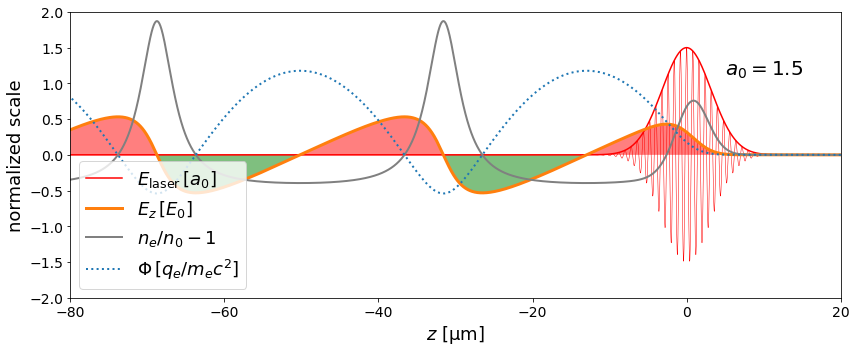

In [17]:
plt.figure(figsize=(12,5))

# laser envelop
plt.plot(xi/1e-6, 
         calc_laser_env(xi, a0=param["a0"]), 
         color="red", 
         lw=1.5, 
         label=r"$E_\mathrm{laser}\, [a_0]$")

# laser with oscilation 
plt.plot(xi/1e-6, 
         calc_laser(xi, a0=param["a0"]), 
         color="red", 
         lw=0.5)

# accelerating electric field
plt.plot(xi[1:]/1e-6, 
         E, 
         "-", 
         lw=3, 
         color="C1", 
         label=r"$E_z \, [E_0]$")
# mark accelerating as green and decelerating as red
plt.fill_between(xi[1:]/1e-6, 
                 E, 0, where=E <= 0, 
                 facecolor='green', alpha=0.5, )
plt.fill_between(xi[1:]/1e-6, 
                 E, 0, where=E > 0, 
                 facecolor='red', alpha=0.5, )

# density
plt.plot(xi/1e-6, np_per_n0-1., lw=2, color="gray", label="$n_e/n_0 -1$")

# potential
plt.plot(xi/1e-6, Phi[:, 0], ":", color="C0", lw=2, label=r"$\Phi \, [q_e/m_e c^2]$")

# mark laser (peak) strength
plt.text(5, 0.75*param["a0"], r"$a_0 = {:2.1f}$".format(param["a0"]), fontsize=20)

# labels
plt.xlabel(r"$z \ \mathrm{[\mu m]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel("normalized scale", fontsize=18)
plt.yticks(fontsize=14)

plt.xlim(-80, 20)
plt.ylim(-2.0, 2.0)

plt.legend(loc=3, fontsize=18)

plt.tight_layout()
plt.show()
